# SYDE 556/750 --- Assignment 1

**Student ID: 20709541**

_Note:_ Please include your numerical student ID only, do _not_ include your name.

_Note:_ Refer to the [PDF](https://github.com/celiasmith/syde556-f22/raw/master/assignments/assignment_01/syde556_assignment_01.pdf) for the full instructions (including some hints), this notebook contains abbreviated instructions only. Cells you need to fill out are marked with a "writing hand" symbol. Of course, you can add new cells in between the instructions, but please leave the instructions intact to facilitate marking.


In [217]:
# Import numpy and matplotlib -- you shouldn't need any other libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sci # For question 2.1b)

# Fix the numpy random seed for reproducible results
np.random.seed(18945)

# Some formating options
%config InlineBackend.figure_formats = ['svg']

# 1. Representation of Scalars

## 1.1 Basic encoding and decoding

**a) Computing gain and bias.** In general, for a neuron model $a = G[J]$ (and assuming that the inverse $J = G^{-1}[a]$ exists), solve the following system of equations to compute the gain $\alpha$, and the bias $J^\mathrm{bias}$ given a maximum rate $a^\mathrm{max}$ and an $x$-intercept $\xi$.

$$a^\mathrm{max} = G[\alpha + J^\mathrm{bias}] \,, \quad\quad 0 = G[\alpha \xi + J^\mathrm{bias}] \,.$$


Solving the following system of equations we see that:

$$
\alpha^\mathrm{max} = G[\alpha + J^\mathrm{bias}] \Rightarrow G^{-1}[\alpha^\mathrm{max}]=a+J^\mathrm{bias} \text{ (1)}
$$

and

$$
0 = G[\alpha \xi + J^\mathrm{bias}] \Rightarrow G^{-1}[0]=\alpha \xi +J^\mathrm{bias} \text{ (2)}
$$

from (2) it follows that

$$
J^\mathrm{bias}=G^{-1}[0]-\alpha \xi \text{ (3)}
$$

then plugging (3) into (1) we see that

$$
G^{-1}[a^\mathrm{max}]=\alpha+G^{-1}[0]-\alpha \xi \text{ (4)}
$$

Re-arranging (4) we can find an equation for $\alpha$ as follows

$$
\alpha = \frac{G^{-1}[a^\mathrm{max}]-G^{-1}[0]}{1-\xi} \text{  (5)}
$$

and plugging (5) back into (3) we can find the following equation for $J^\mathrm{bias}$

$$
J^\mathrm{bias}=G^{-1}[0]-\xi \left\{\frac{G^{-1}[a^\mathrm{max}]-G^{-1}[0]}{1-\xi}\right\} \text{ (6)}
$$


Now, simplify these equations for the specific case $G[J] = \max(J, 0)$.


When $G[J]=\max(J,0)$ being the rectified linear rate approximation of a neuron then we know that for the case when $J \gt J^{th}$ then $G[J]=J$, and is 0 otherwise. Using this information we can simplfy our equations for the gain and bias into the following:

$$
\alpha^\mathrm{max} = G[\alpha + J^\mathrm{bias}] \Rightarrow \alpha^\mathrm{max}=\alpha + J^\mathrm{bias} \text{ (7)}
$$

and

$$
0 = G[\alpha \xi + J^\mathrm{bias}] \Rightarrow 0=\alpha \xi +J^\mathrm{bias} \text{ (8)}
$$

Solving equations (7) and (8) we find that

$$
\alpha=\frac{\alpha^\mathrm{max}}{1-\xi} \text{ (9)}
$$

or

$$
\alpha = \frac{\alpha^\mathrm{max}}{|\bold{e}-\bold{x}|}
$$

where $\bold{e}$ is the encoder sign and $x$ is the position. In the same sense, $J^\mathrm{bias}$ can be expressed as

$$
J^\mathrm{bias}=\xi \frac{-\alpha^\mathrm{max}}{1-\xi} \text{ (10)}
$$

or

$$
J^\mathrm{bias}=-\alpha\cdot\langle\bold{e},\bold{x}\rangle
$$

We also know that in the case of the ReLU rate approximation encoder, $J^{th}$ being the maximum current that results in a zero output rate corresponds directly with the $x-intercept$ $\xi$


**b) Neuron tuning curves.** Plot the neuron tuning curves $a_i(x)$ for 16 randomly generated neurons following the intercept and maximum rate distributions described above.


In [218]:
number_of_neurons = 16

Generate random $a^{max}$ uniformely distributed between 100Hz and 200Hz


In [219]:
low_freq = 100 # Hz
high_freq = 200 # Hz
num_a_max_samples = number_of_neurons
a_max_set = np.random.uniform(low_freq, high_freq, num_a_max_samples)

Generate random $x-intercepts$ $\xi$ uniformly distributed between -0.95 and 0.95

In [220]:
min_intercept = -0.95
max_intercept = 0.95
num_intercepts = number_of_neurons
intercept_set = np.random.uniform(min_intercept, max_intercept, num_intercepts)

Create helper functions:

In [221]:
tau_ref = 0.002
tau_rc = 0.020


def gain(a_max, x_intercept, e, type):
    if type == "relu":
        return a_max / abs(e - x_intercept)
    if type == "lif":
        encode = abs(e - x_intercept)
        exp_term = 1 - np.exp((tau_ref - 1 / a_max) / tau_rc)
        return 1 / (encode * exp_term)
    if type == "lif-2d":
        encode = np.vdot(e, e) - np.vdot(e, x_intercept)
        exp_term = 1 - np.exp((tau_ref - 1 / a_max) / tau_rc)
        return 1 / (encode * exp_term)
    return 0


def bias(x_intercept, e, gain, type):
    if type == "relu":
        return -(gain) * x_intercept * e
    if type == "lif":
        return -(gain) * x_intercept * e
    if type == "lif-2d":
        return -(gain) * np.vdot(e, x_intercept)
    return 0


def relu_encode(neuron, x):
    rate = max(neuron.a * x * neuron.encoder_sign + neuron.j_bias, 0)
    return rate


def lif_encode(neuron, x):
    J = neuron.a * x * neuron.encoder_sign + neuron.j_bias
    if J > 1:
        return 1 / (tau_ref - tau_rc * np.log(1 - 1 / J))
    return 0


def lif_encode_2d(neuron, xy):
    J = neuron.a * np.vdot(xy, neuron.circ) + neuron.j_bias
    if J > 1:
        return 1 / (tau_ref - tau_rc * np.log(1 - 1 / J))
    return 0


def print_block(title, data):
    print(title + " ----------")
    print(data)
    print("-----------------")

In [222]:



class Neuron:
    def __init__(self, a_max, x_intercept, id, type):
        self.id = id
        self.a_max = a_max
        self.encoder_sign = np.random.choice([-1, 1])
        a = gain(a_max, x_intercept, self.encoder_sign, type)
        j_bias = bias(x_intercept, self.encoder_sign, a, type)
        self.a = a
        self.j_bias = j_bias
        self.rate = []

    def rate_at_point(self, x, type):
        if type == "relu":
            return relu_encode(self, x)
        if type == "lif":
            return lif_encode(self, x)

    def find_rate(self, space, type):
        for element in space:
            self.rate.append(self.rate_at_point(element, type))

    def print_details(self):
        print("Neuron: --------------")
        print("id " + str(self.id))
        print("a_max " + str(self.a_max))
        print("gain " + str(self.a))
        print("bias " + str(self.j_bias))
        print("--------------")


# create array of neuron objects
neurons = []
for i in range(number_of_neurons):
    neurons.append(Neuron(a_max_set[i], intercept_set[i], i, "relu"))

# create a linespace for us to plot
x = np.linspace(-1, 1, 41)

for neuron in neurons:
    neuron.find_rate(x, "relu")

Plot the ReLU encoder rates $a_i(x)$ over their input $x$

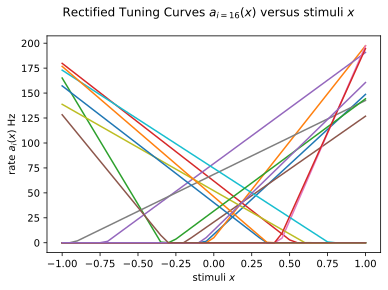

In [223]:
plt.figure()
plt.suptitle("Rectified Tuning Curves $a_{i=16}(x)$ versus stimuli $x$")
for neuron in neurons:
    plt.plot(x, neuron.rate)
plt.xlabel("stimuli $x$")
plt.ylabel("rate $a_i(x)$ Hz")
plt.show()

**c) Computing identity decoders.** Compute the optimal identity decoder $\vec d$ for those 16 neurons (as shown in class). Report the value of the individual decoder coefficients. Compute $d$ using the matrix notation mentioned in the course notes. Do not apply any regularization. $A$ is the matrix of activities (the same data used to generate the plot in 1.1b).


Solving the problem (below) of least squares for the general case when $d$ is dimension $N$ as $\bold{D}$ see that
$$
\bold{D^T}\approx(\bold{A}\bold{A^T})^{-1}\bold{A}\bold{X^T}
$$

In [224]:
# make a list of all the activities
activities = []
inputs = []
for neuron in neurons:
    activities.append(neuron.rate)
    inputs.append(x)

# make A matrix
A = np.array(activities)
X = np.array(inputs)

# Calculate Decoders
D = np.linalg.lstsq(A.T, X.T, rcond=None)[0].T[0]

print_block("Decoders",D)

Decoders ----------
[-9.04442718e-05 -8.18141634e-05  9.40587950e-04 -1.39753131e-03
  5.26991976e-05 -1.32515445e-03 -6.58968919e-04 -4.26051588e-04
  8.56513564e-04 -1.80305414e-04  9.20342728e-03 -1.03734207e-02
  6.72187738e-03  1.82491677e-03  3.28703379e-04 -4.72469121e-03]
-----------------


**d) Evaluating decoding errors.** Compute and plot $\hat{x}=\sum_i d_i a_i(x)$. Overlay on the plot the line $y=x$. Make a separate plot of $x-\hat{x}$ to see what the error looks like. Report the Root Mean Squared Error (RMSE) value.


Plotting decoded values $\hat x$ and the true input values $x$

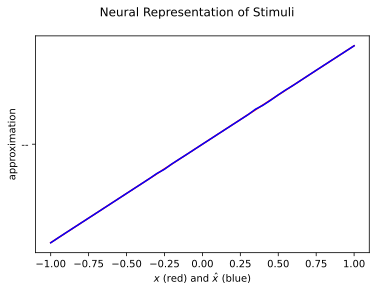

In [225]:
x_hat = np.dot(D, A)
plt.figure()
plt.suptitle("Neural Representation of Stimuli")
plt.plot(x, x, "r", "--")
plt.plot(x, x_hat, "b")
plt.xlabel("$x$ (red) and $\hat x$ (blue)")
plt.ylabel("approximation")
plt.show()

Plotting the difference betwee $\hat x$ and $x$, $E = x - \hat x$ 

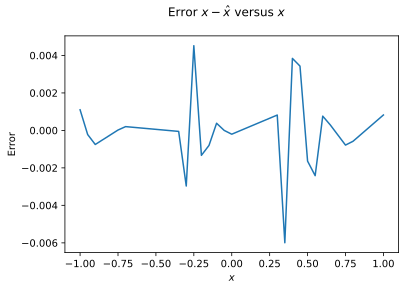

In [226]:
err = x - x_hat
plt.figure()
plt.suptitle("Error $x-\hat x$ versus $x$")
plt.plot(x, err)
plt.xlabel("$x$")
plt.ylabel("Error")
plt.show()

Report the Root Mean Squared Error (RMSE)

In [227]:
def rmse(x1, x2):
    return np.sqrt(np.mean(np.power(x1 - x2, 2)))


x_rmse = rmse(x, x_hat)
x_rmse_rounded = np.round(x_rmse, 10)
print_block("Root Mean Squared Error", x_rmse_rounded)

Root Mean Squared Error ----------
0.0016309119
-----------------


**e) Decoding under noise.** Now try decoding under noise. Add random normally distributed noise to $a$ and decode again. The noise is a random variable with mean $\mu=0$ and standard deviation of $\sigma=0.2 \max(A)$ (where $\max(A)$ is the maximum firing rate of all the neurons). Resample this variable for every different $x$ value for every different neuron. Create all the same plots as in part d). Report the RMSE.


Generate $\hat x_{noise}$

In [228]:
noise_sdtdev = 0.2 * np.amax(A)
W_noise = np.random.normal(scale=noise_sdtdev, size=np.shape(A))
A_noise = A + W_noise
x_hat_noise = np.dot(D, A_noise)

Plot decoded $\hat x_{noise}$ versus original $x$

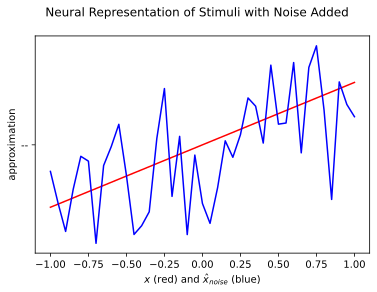

In [229]:
plt.figure()
plt.suptitle("Neural Representation of Stimuli with Noise Added")
plt.plot(x, x, "r", "--")
plt.plot(x, x_hat_noise, "b")
plt.xlabel("$x$ (red) and $\hat x_{noise}$ (blue)")
plt.ylabel("approximation")
plt.show()

Plotting the difference betwee $\hat x_{noise}$ and $x$, $E_{noise} = x - \hat x_{noise}$ 

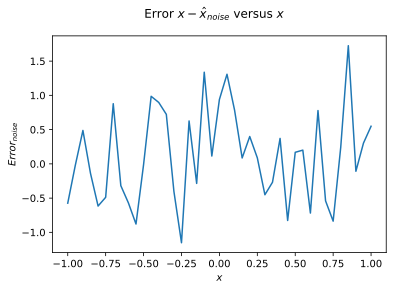

In [230]:
err_noise = x - x_hat_noise
plt.figure()
plt.suptitle("Error $x-\hat x_{noise}$ versus $x$")
plt.plot(x, err_noise)
plt.xlabel("$x$")
plt.ylabel("$Error_{noise}$")
plt.show()

Report the Root Mean Squared Error (RMSE)

In [231]:
x_rmse_noise = rmse(x, x_hat_noise)
x_rmse_noise_rounded=np.round(x_rmse_noise, 10)
print_block("Root Mean Squared Error (Noise) ", x_rmse_noise_rounded)

Root Mean Squared Error (Noise)  ----------
0.6866944254
-----------------


**f) Accounting for decoder noise.** Recompute the decoder $\vec d$ taking noise into account (i.e., apply the appropriate regularization, as shown in class). Show how these decoders behave when decoding both with and without noise added to $a$ by making the same plots as in d) and e). Report the RMSE for all cases.


Taking noise into account and performing regularization we see that
$$
\bold{D} \approx (\bold{A}\bold{A^{T}}+N\sigma^{2}\bold{I})^{-1}\bold{A}\bold{X^{T}}
$$

In [232]:
# taking noise into account
N = len(x)
n = number_of_neurons
D_noisey = np.linalg.lstsq(
    A @ A.T + 0.5 * N * np.square(noise_sdtdev) * np.eye(n),
    A @ X.T,
    rcond=None,
)[0].T[0]

print_block("Noisey Decoders",D_noisey)

Noisey Decoders ----------
[ 0.00052308  0.00066024 -0.00089647 -0.00092633  0.00113458  0.00054764
  0.00042239  0.00084794 -0.00068381 -0.00078467 -0.00089853 -0.00100487
  0.00069608  0.00042051  0.00058708 -0.0007256 ]
-----------------


Plotting decoded values $\hat x$ and the true input values $x$ using noisey Decoders $\bold{d_{noisey}}$

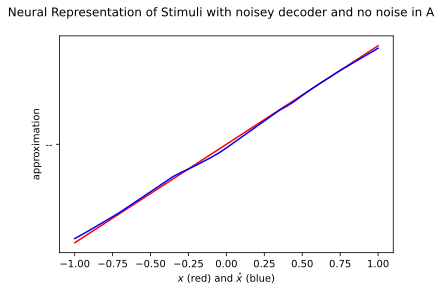

In [233]:
x_hat_noisey_decoder = np.dot(D_noisey, A)
plt.figure()
plt.suptitle("Neural Representation of Stimuli with noisey decoder and no noise in A")
plt.plot(x, x, "r", "--")
plt.plot(x, x_hat_noisey_decoder, "b")
plt.xlabel("$x$ (red) and $\hat x$ (blue)")
plt.ylabel("approximation")
plt.show()

Plotting the difference betwee $\hat x$ and $x$, $E = x - \hat x$ using noisey Decoders $\bold{d_{noisey}}$

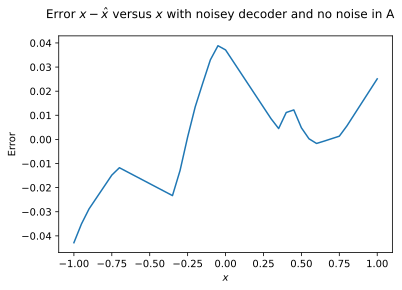

In [234]:
err_noise_decoder = x - x_hat_noisey_decoder
plt.figure()
plt.suptitle("Error $x-\hat x$ versus $x$ with noisey decoder and no noise in A")
plt.plot(x, err_noise_decoder)
plt.xlabel("$x$")
plt.ylabel("Error")
plt.show()

Report the Root Mean Squared Error (RMSE)

In [235]:
x_rmse_noisey_decoder = rmse(x, x_hat_noisey_decoder)
x_rmse_noisey_decoder_rounded = np.round(x_rmse_noisey_decoder, 10)
print_block("Root Mean Squared Error (Noisey Decoder) and no noise in A ", x_rmse_noisey_decoder_rounded)

Root Mean Squared Error (Noisey Decoder) and no noise in A  ----------
0.0204626651
-----------------


Plotting decoded values $\hat x$ and the true input values $x$ using noisey Decoders $\bold{d_{noisey}}$ and noisey activities $\bold{A_{noise}}$

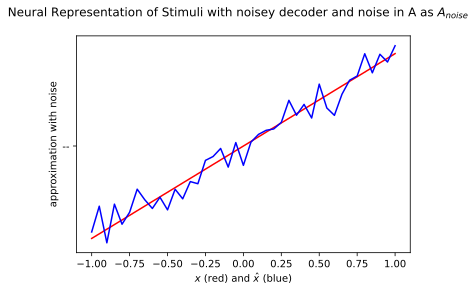

In [236]:
x_hat_noisey_decoder_noisey_A = np.dot(D_noisey, A_noise)
plt.figure()
plt.suptitle(
    "Neural Representation of Stimuli with noisey decoder and noise in A as $A_{noise}$"
)
plt.plot(x, x, "r", "--")
plt.plot(x, x_hat_noisey_decoder_noisey_A, "b")
plt.xlabel("$x$ (red) and $\hat x$ (blue)")
plt.ylabel("approximation with noise")
plt.show()

Plotting the difference betwee $\hat x$ and $x$, $E = x - \hat x$ using noisey Decoders $\bold{d_{noisey}}$ and noisey activities $\bold{A_{noise}}$

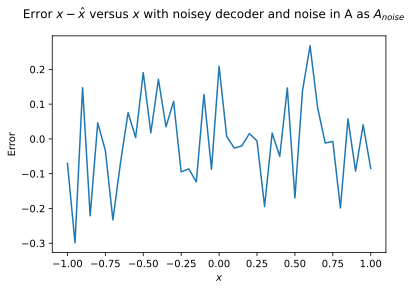

In [237]:
err_noise_decoder_noisey_A = x - x_hat_noisey_decoder_noisey_A
plt.figure()
plt.suptitle(
    "Error $x-\hat x$ versus $x$ with noisey decoder and noise in A as $A_{noise}$"
)
plt.plot(x, err_noise_decoder_noisey_A)
plt.xlabel("$x$")
plt.ylabel("Error")
plt.show()

Report the Root Mean Squared Error (RMSE)

In [238]:
x_rmse_noisey_decoder_noisey_A = rmse(x, x_hat_noisey_decoder_noisey_A)
x_rmse_noisey_decoder_noisey_A_rounded = np.round(x_rmse_noisey_decoder_noisey_A, 10)
print_block(
    "Root Mean Squared Error (Noisey Decoder) and noise in A",
    x_rmse_noisey_decoder_noisey_A_rounded,
)

Root Mean Squared Error (Noisey Decoder) and noise in A ----------
0.1270503631
-----------------


**g) Interpretation.** Show a 2x2 table of the four RMSE values reported in parts d), e), and f). This should show the effects of adding noise and whether the decoders $d$ are computed taking noise into account. Write a few sentences commenting on what the table shows, i.e., what the effect of adding noise to the activities is with respect to the measured error and why accounting for noise when computing the decoders increases/decreases/does not change the measured RMSE.


Plotting the table of all the different RMSE values


<Figure size 432x288 with 0 Axes>

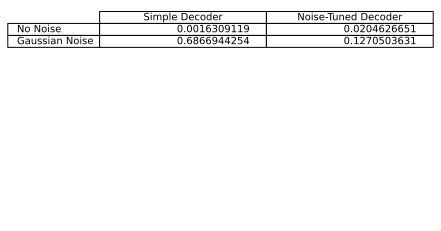

In [239]:
plt.figure()
fig, ax = plt.subplots()
ax.set_axis_off()
rmse_table_values = [
    [x_rmse_rounded, x_rmse_noisey_decoder_rounded],
    [x_rmse_noise_rounded, x_rmse_noisey_decoder_noisey_A_rounded],
]
table_rows = ["No Noise", "Gaussian Noise"]
table_cols = ["Simple Decoder", "Noise-Tuned Decoder"]
plt.table(
    cellText=rmse_table_values,
    rowLabels=table_rows,
    colLabels=table_cols,
    loc="upper left",
)
plt.show()

When adding noise to the activities in the case of a simple decoder, the noise causes an increase in the RMSE of nearly $10^2$. In the case of the noise-tuned decoder without nouse the error increases on an order of magnitude of $10^1$. In the case where there is noise-optimized decoder and there is noise, the RMSE is still greater on an order of magnitude $10^2$ but less than the case when there is no noise-optimized decoder. It appears in the above case that optimizing the decoder to account noise results in a "better" worse case, but a "worse" better case, for example, in the case where there is no noise". The overall result is what appears to be less variance in the RMSE when using the noise-optimized decoder $\bold{D_{noise}}$

## 1.2 Exploring sources of error

**a) Exploring error due to distortion and noise.** Plot the error due to distortion $E_\mathrm{dist}$ and the error due to noise $E_\mathrm{noise}$ as a function of $n$, the number of neurons. Generate two different loglog plots (one for each type of error) with $n$ values of at least $[4, 8, 16, 32, 64, 128, 256, 512]$. For each $n$ value, do at least $5$ runs and average the results. For each run, different $\alpha$, $J^\mathrm{bias}$, and $e$ values should be generated for each neuron. Compute $d$ taking noise into account, with $\sigma = 0.1 \max(A)$. Show visually that the errors are proportional to $1/n$ or $1/n^2$.


In [240]:
num_neurons_to_eval = [4, 8, 16, 32, 64, 128, 256, 512]
num_runs = 5


def find_error(stddev_factor, runs, neurons_to_eval):
    E_dist = []
    E_noise = []
    for amount_of_neurons in num_neurons_to_eval:
        e_dist = []
        e_noise = []
        for r in range(runs):
            local_neurons = []
            for i in range(amount_of_neurons):
                local_neurons.append(
                    Neuron(
                        np.random.uniform(low_freq, high_freq),
                        np.random.uniform(min_intercept, max_intercept),
                        i,
                        "relu",
                    )
                )
            local_activies = []
            local_inputs = []
            for neuron in local_neurons:
                neuron.find_rate(x, "relu")
            for neuron in local_neurons:
                local_activies.append(neuron.rate)
                local_inputs.append(x)
            # make A matrix
            A_L = np.array(local_activies)
            X_L = np.array(local_inputs)
            sigma_noise = stddev_factor * np.amax(A_L)
            N_L = len(x)
            n_L = len(local_neurons)
            D_L_noisey = np.linalg.lstsq(
                A_L @ A_L.T + 0.5 * N_L * np.square(sigma_noise) * np.eye(n_L),
                A_L @ X_L.T,
                rcond=None,
            )[0].T[0]
            local_x_hat = np.dot(D_L_noisey, A_L)
            e_dist_L = sum(np.power(x - local_x_hat, 2)) / N_L
            e_noise_L = sigma_noise * sum(np.power(D_L_noisey, 2))
            e_dist.append(e_dist_L)
            e_noise.append(e_noise_L)

        E_dist.append(np.mean(e_dist))
        E_noise.append(np.mean(e_noise))

    return E_dist, E_noise

Find Errors $E_{dist}$ and $E_{noise}$ and create $\frac{1}{n}$ and $\frac{1}{n^{2}}$

In [241]:
factor_1 = 0.1
error_dist, error_noise = find_error(factor_1, num_runs, num_neurons_to_eval)

n = [1 / N for N in num_neurons_to_eval]
n2 = [1 / np.power(N, 2) for N in num_neurons_to_eval]

In [242]:
# function to plot the error
def plot_error(title, source):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    plt.suptitle(title)
    plt_error = ax.plot(num_neurons_to_eval, source, label="Error")
    plt_n = ax.plot(num_neurons_to_eval, n, "--", label="$1/n$")
    plt_n2 = ax.plot(num_neurons_to_eval, n2, "--", label="$1/n^2$")
    plt.legend(handles=[plt_error, plt_n, plt_n2], labels=[])
    ax.set_xscale("log")
    ax.set_yscale("log")
    plt.xlabel("Number of neurons")
    plt.ylabel("$E_{noise}$")
    plt.show()

Plot $E_{noise}$ alonside to $1/n$ or $1/n^2$

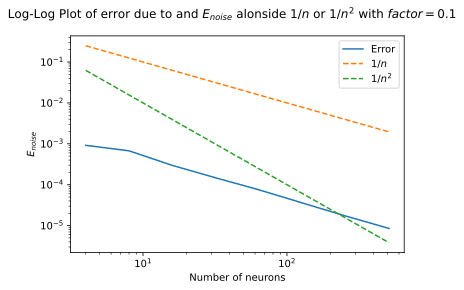

In [243]:
plot_error(
    "Log-Log Plot of error due to and $E_{noise}$ alonside $1/n$ or $1/n^2$ with $factor=0.1$",
    error_noise,
)

Plot $E_{dist}$ alonside to $1/n$ or $1/n^2$

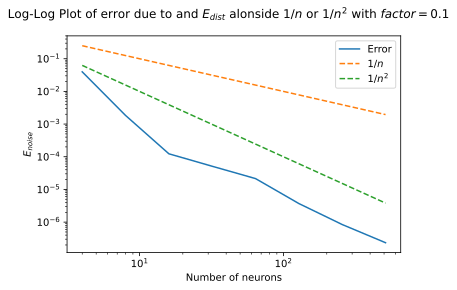

In [244]:
plot_error(
    "Log-Log Plot of error due to and $E_{dist}$ alonside $1/n$ or $1/n^2$ with $factor=0.1$",
    error_dist,
)

**b) Adapting the noise level.** Repeat part a) with $\sigma = 0.01 \max(A)$.


In [245]:
factor_2 = 0.01
error_dist_2, error_noise_2 = find_error(factor_2, num_runs, num_neurons_to_eval)

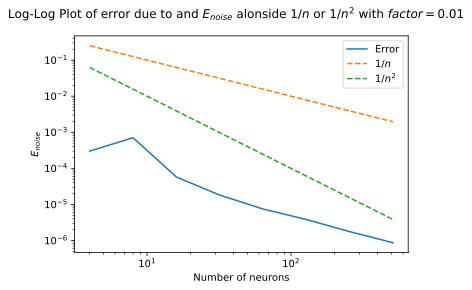

In [246]:
plot_error(
    "Log-Log Plot of error due to and $E_{noise}$ alonside $1/n$ or $1/n^2$ with $factor=0.01$",
    error_noise_2,
)

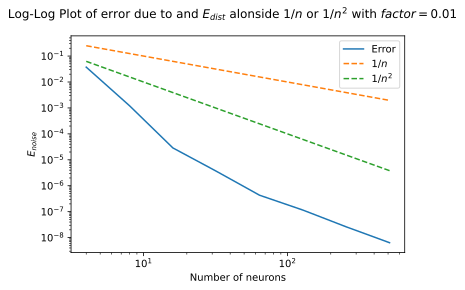

In [247]:
plot_error(
    "Log-Log Plot of error due to and $E_{dist}$ alonside $1/n$ or $1/n^2$ with $factor=0.01$",
    error_dist_2,
)

**c) Interpretation.** What does the difference between the graphs in a) and b) tell us about the sources of error in neural populations?


As the number of neurons, $n \to \infty$ the error decreases on an order of magnitude. In the graphs in (a) we can see that the larger standard deviation caused by the factor of 0.1 causes a decrease in error of lesser magnutide relative to that of the graphs in (b) which see a greater decrease in magnitude. It also appears in the graphs that the error due to noise $E_{noise}$ is related to a $1/n$ relationship with the number of neurons and the distortion error $E_{dist}$ is related to the $1/n^2$ relationship witht the number of neurons. That is to say as the number of neurons increases the decrease in error due to distortion will more significant. In either case, a greater neuron population will result in a decreased error, but an increase in noise. 


## 1.3 Leaky Integrate-and-Fire neurons

**a) Computing gain and bias.** As in the second part of 1.1a), given a maximum firing rate $a^\mathrm{max}$ and a bias $J^\mathrm{bias}$, write down the equations for computing $\alpha$ and the $J^\mathrm{bias}$ for this specific neuron model.


Given that when $J = 1$: $G[J] = \frac{1}{\tau_{ref}-\tau_{RC}{\ln{1-\frac{1}{J}}}}$ and $G[J]=0$ otherwise, we can express the equations as follows:

since

$$a^\mathrm{max} = G[\alpha + J^\mathrm{bias}] \,, \quad\quad 0 = G[\alpha \xi + J^\mathrm{bias}] \,$$

then

$$
a^\mathrm{max}=\frac{1}{\tau_{ref}-\tau_{RC}{\ln{\left(1-\frac{1}{\alpha + J^\mathrm{bias}}\right)}}} \,, \quad\quad 0 =\alpha \xi + J^\mathrm{bias} \,
$$
These can be re-arranged into the following equations
$$
\frac{1}{\alpha+J^\mathrm{bias}}=1-\exp(\frac{\tau_{ref-\frac{1}{a^\mathrm{max}}}}{\tau_{RC}}) \,, \quad\quad J^\mathrm{bias}=-\alpha \xi
$$
plugging in $-\alpha \xi$ in place of $J^\mathrm{bias}$ into the above relationship allows us to solve for the gain $\alpha$ and then subsequently $J^\mathrm{bias}$ in the following equations

$$
\alpha=\frac{1}{(1-\xi)\left(1-\exp(\frac{\tau_{ref-\frac{1}{a^\mathrm{max}}}}{\tau_{RC}})\right)} \,, \quad\quad J^\mathrm{bias}=-\alpha \xi
$$

**b) Neuron tuning curves.** Generate the same plot as in 1.1b). Use $\tau_\mathrm{ref}=2 \mathrm{ms}$ and $\tau_{RC}=20 \mathrm{ms}$. Use the same distribution of $x$-intercepts and maximum firing rates as in 1.1.


In [248]:
lif_neurons = []
for i in range(number_of_neurons):
    lif_neurons.append(Neuron(a_max_set[i], intercept_set[i], i, "lif"))

# create a linespace for us to plot
x = np.linspace(-1, 1, 41)

for neuron in lif_neurons:
    neuron.find_rate(x, "lif")


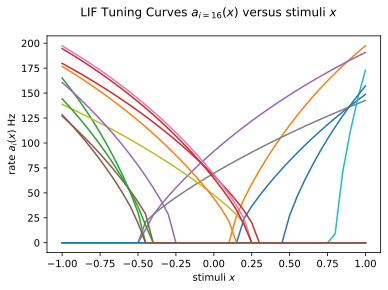

In [249]:
plt.figure()
plt.suptitle("LIF Tuning Curves $a_{i=16}(x)$ versus stimuli $x$")
for neuron in lif_neurons:
    plt.plot(x, neuron.rate)
plt.xlabel("stimuli $x$")
plt.ylabel("rate $a_i(x)$ Hz")
plt.show()

**c) Impact of noise.** Generate the same four plots as in 1.1f) (adding/not adding noise to $A$, accounting/not accounting for noise when computing $\vec d$), and report the RMSE both with and without noise.


In [250]:
lif_activities = []
lif_inputs = []
for neuron in lif_neurons:
    lif_activities.append(neuron.rate)
    lif_inputs.append(x)

# make A matrix and matrix of activities
A_LIF = np.array(lif_activities)
X_LIF = np.array(lif_inputs)
lif_noise_sdtdev = 0.2 * np.amax(A_LIF)
W_noise_lif = np.random.normal(scale=lif_noise_sdtdev, size=np.shape(A_LIF))
A_noise_lif = A_LIF + W_noise_lif

In [251]:
N_LIF = len(x)
n_lif = number_of_neurons
D_noisey_lif = np.linalg.lstsq(
    A_LIF @ A_LIF.T + 0.5 * N_LIF * np.square(lif_noise_sdtdev) * np.eye(n_lif),
    A_LIF @ X_LIF.T,
    rcond=None,
)[0].T[0]

print_block("Noisey LIF Decoders", D_noisey_lif)

Noisey LIF Decoders ----------
[ 0.0008891   0.0011683  -0.00052936 -0.0006679   0.00115335 -0.00038266
 -0.00071348  0.00083195 -0.00049516  0.0005447   0.00106202 -0.00069248
 -0.00045101 -0.00071007 -0.00056998 -0.0004199 ]
-----------------


**Case with noise optimized decoders and no noise in A**

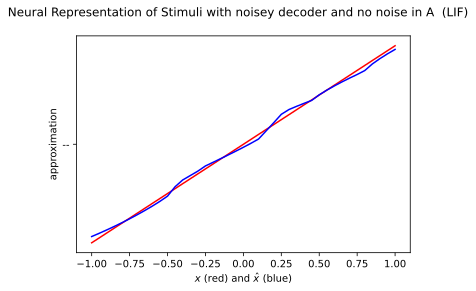

In [252]:
x_hat_noisey_decoder_lif = np.dot(D_noisey_lif, A_LIF)
plt.figure()
plt.suptitle("Neural Representation of Stimuli with noisey decoder and no noise in A  (LIF)")
plt.plot(x, x, "r", "--")
plt.plot(x, x_hat_noisey_decoder_lif, "b")
plt.xlabel("$x$ (red) and $\hat x$ (blue)")
plt.ylabel("approximation")
plt.show()

Plotting the difference betwee $\hat x_{LIF}$ and $x_{LIF}$, $E = x_{LIF} - \hat x_{LIF}$ using noisey Decoders $\bold{d_{noisey}}$

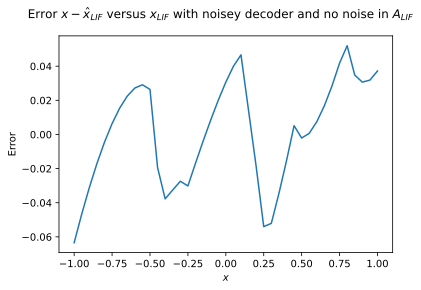

In [253]:
err_noise_decoder_lif = x - x_hat_noisey_decoder_lif
plt.figure()
plt.suptitle(
    "Error $x-\hat x_{LIF}$ versus $x_{LIF}$ with noisey decoder and no noise in $A_{LIF}$"
)
plt.plot(x, err_noise_decoder_lif)
plt.xlabel("$x$")
plt.ylabel("Error")
plt.show()

Report Root mean squared error (RMSE)

In [254]:
x_rmse_noisey_decoder_lif = rmse(x, x_hat_noisey_decoder_lif)
x_rmse_noisey_decoder_rounded_lif = np.round(x_rmse_noisey_decoder_lif, 10)
print_block(
    "Root Mean Squared Error (Noisey Decoder) and no noise in A",
    x_rmse_noisey_decoder_rounded_lif,
)

Root Mean Squared Error (Noisey Decoder) and no noise in A ----------
0.0305808108
-----------------


**Case with noise optimized decoders and noise in A**

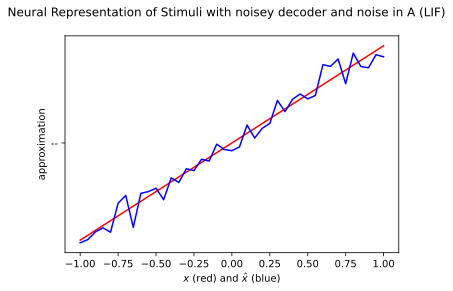

In [255]:
x_hat_noisey_decoder_noisey_A_lif = np.dot(D_noisey_lif, A_noise_lif)
plt.figure()
plt.suptitle(
    "Neural Representation of Stimuli with noisey decoder and noise in A (LIF)"
)
plt.plot(x, x, "r", "--")
plt.plot(x, x_hat_noisey_decoder_noisey_A_lif, "b")
plt.xlabel("$x$ (red) and $\hat x$ (blue)")
plt.ylabel("approximation")
plt.show()

Plotting the difference betwee $\hat x_{LIF}$ and $x_{LIF}$, $E = x_{LIF} - \hat x_{LIF}$ using noisey Decoders $\bold{d_{noisey}}$ and noisey matrix of activities $\bold{A_{noisey}}$

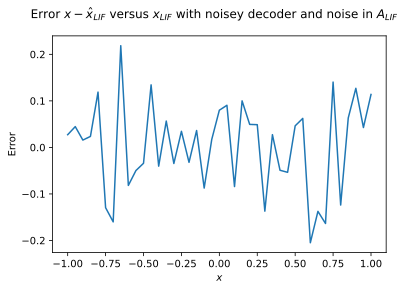

In [256]:
err_noise_decoder_noisey_A_lif = x - x_hat_noisey_decoder_noisey_A_lif
plt.figure()
plt.suptitle(
    "Error $x-\hat x_{LIF}$ versus $x_{LIF}$ with noisey decoder and noise in $A_{LIF}$"
)
plt.plot(x, err_noise_decoder_noisey_A_lif)
plt.xlabel("$x$")
plt.ylabel("Error")
plt.show()

Report Root Mean Squared Error (RMSE)

In [257]:
x_rmse_noisey_decoder_noisey_A_lif = rmse(x, x_hat_noisey_decoder_noisey_A_lif)
x_rmse_noisey_decoder_noisey_A_rounded_lif = np.round(
    x_rmse_noisey_decoder_noisey_A_lif, 10
)
print_block(
    "Root Mean Squared Error (Noisey Decoder) and noise in A",
    x_rmse_noisey_decoder_noisey_A_rounded_lif,
)

Root Mean Squared Error (Noisey Decoder) and noise in A ----------
0.0961018259
-----------------


# 2. Reperesentation of Vectors

## 2.1 Vector tuning curves

**a) Plotting 2D tuning curves.** Plot the tuning curve of an LIF neuron whose 2D preferred direction vector is at an angle of $\theta=-\pi/4$, has an $x$-intercept at the origin $(0,0)$, and has a maximum firing rate of $100 \mathrm{Hz}$.


Create 2D LIF Neuron Class

In [258]:
class LIFNeuron2D:
    def __init__(self, a_max, x_intercept, angle, id):
        self.id = id
        self.a_max = a_max
        self.circ = [np.cos(angle), np.sin(angle)]
        a = gain(a_max, x_intercept, self.circ, "lif-2d")
        j_bias = bias(x_intercept, self.circ, a, "lif-2d")
        self.a = a
        self.j_bias = j_bias
        self.rate = []

    def rate_at_point(
        self,
        point,
    ):
        return lif_encode_2d(self, point)

    def find_rate(self, point):
        self.rate.append(self.rate_at_point(point))

    def find_rate_2d(self, set):
        for point in set:
            self.rate.append(self.rate_at_point(point))

    def clear_rate(self):
        self.rate = []

    def print_details(self):
        print("Neuron: --------------")
        print("id " + str(self.id))
        print("a_max " + str(self.a_max))
        print("gain " + str(self.a))
        print("angle " + str(self.circ))
        print("bias " + str(self.j_bias))
        print("--------------")

Instanciate 2D LIF Neuron and find required rates

In [259]:
a_max2d = 100
angle = -np.pi / 4
x_intercept = [0, 0]

neuron2d = LIFNeuron2D(a_max2d, x_intercept, angle, 0)

l = 41

x, y = np.linspace(-1, 1, l), np.linspace(-1, 1, l)
x, y = np.meshgrid(x, y)
points = []
for i in range(len(x)):
    for j in range(len(x)):
        points.append([x[j][i], y[j][i]])


for point in points:
    neuron2d.find_rate(point)

rates = neuron2d.rate
rates = np.reshape(rates, (l, l))

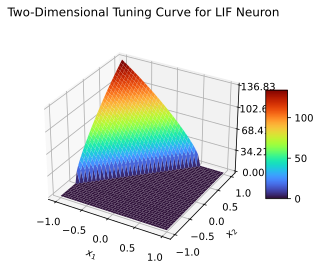

In [260]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
plt.suptitle("Two-Dimensional Tuning Curve for LIF Neuron")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
ax.set_zlabel("$a$ (Hz)")
surf = ax.plot_surface(
    X=x, Y=y, Z=rates, cmap=cm.turbo, linewidth=0, antialiased=False
)
ax.zaxis.set_major_locator(LinearLocator(5))
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.zaxis.set_major_formatter('{x:.02f}')

plt.show()

**b) Plotting the 2D tuning curve along the unit circle.** Plot the tuning curve for the same neuron as in a), but only considering the points around the unit circle, i.e., sample the activation for different angles $\theta$. Fit a curve of the form $c_1 \cos(c_2\theta+c_3)+c_4$ to the tuning curve and plot it as well.


In [261]:
def fcos(theta, c1, c2, c3, c4):
    return c1 * np.cos(c2 * theta + c3) + c4


samples = 250
thetas = np.linspace(-np.pi, np.pi, samples)

# clear the rates from the previous  question
neuron2d.clear_rate()

for theta in thetas:
    neuron2d.find_rate([np.cos(theta), np.sin(theta)])

theta_rates = neuron2d.rate

popt, pcov = sci.curve_fit(fcos, thetas, theta_rates)

fit = []

for theta in thetas:
    fit.append(fcos(theta, *popt))

**c) Discussion.** What makes a cosine a good choice for the curve fit in 2.1b? Why does it differ from the ideal curve?


Because the curve we are trying to fit has exponential characteristics, a cosine function is not a bad choise. It also has the shape of a bell curve in many cases. Where it differs from the ideal curve is that it is continuous in nature and consequently is defined in regions in which the value of the tuning curve is 0, as we can see in the graph. It is a these points that it fails.


## 2.2 Vector representation

**a) Choosing encoding vectors.** Generate a set of $100$ random unit vectors uniformly distributed around the unit circle. These will be the encoders $\vec e$ for $100$ neurons. Plot these vectors with a quiver or line plot (i.e., not just points, but lines/arrows to the points).


In [262]:
def generate_encoders(samples):
    thetas = []
    encs = []
    for i in range(samples):
        theta = np.random.uniform(0, 2 * np.pi)
        enc = [np.cos(theta), np.sin(theta)]
        thetas.append(theta)
        encs.append(enc)

    return encs, thetas

num_samples = 100
encs, thetas = generate_encoders(num_samples)


**b) Computing the identity decoder.** Use LIF neurons with the same properties as in question 1.3. When computing the decoders, take into account noise with $\sigma = 0.2\max(A)$. Plot the decoders in the same way you plotted the encoders.


In [312]:
l = 41

x, y = np.linspace(-1, 1, l), np.linspace(-1, 1, l)
x, y = np.meshgrid(x, y)
inputs = []
for i in range(len(x)):
    for j in range(len(x)):
        inputs.append([x[j][i], y[j][i]])

neurons = []

for theta in thetas:
    a_max = np.random.uniform(low_freq, high_freq)
    angle = np.random.uniform(0, 2 * np.pi)
    x_intercept = [np.cos(angle), np.sin(angle)]
    neuron = LIFNeuron2D(a_max, x_intercept, theta, theta)
    neurons.append(neuron)

for neuron in neurons:
    neuron.find_rate_2d(inputs)

activities = []
for neuron in neurons:
    activities.append(neuron.rate)

# make A matrix and matrix of activities
A = np.array(activities)
X = np.array(inputs)
noise_sdtdev = 0.2 * np.amax(A)
W_noise = np.random.normal(scale=noise_sdtdev, size=np.shape(A))
A_noise_lif = A + W_noise

N = len(inputs)
n = len(neurons)
D = np.linalg.lstsq(
    A @ A.T + 0.5 * N * np.square(noise_sdtdev) * np.eye(n),
    A @ X,
    rcond=None,
)[0].T[0]

print_block("Noisey LIF Decoders", D)

Noisey LIF Decoders ----------
[ 6.45516942e-05 -2.70285046e-04 -4.00001032e-04  5.08828043e-05
 -8.74371571e-05  6.67611191e-05 -2.82044977e-04  1.50550039e-04
  8.76803339e-05  4.87986074e-05  2.31753165e-04 -1.76623153e-04
 -6.08914082e-05 -3.35623173e-05  6.25234172e-05  2.66859953e-04
 -1.62553292e-05  2.83843811e-04 -3.47103801e-04  2.90740992e-04
  2.45579922e-04 -6.89892923e-05 -1.48538900e-04  3.75449741e-04
  3.39745045e-04 -2.74481812e-04  2.91487494e-04 -1.61730820e-05
 -7.92742321e-06  3.75525987e-05  5.38167511e-05  1.08732221e-04
 -4.09251381e-05 -1.71698463e-04  5.14171368e-05  6.77866087e-05
 -2.02880323e-04  7.41744071e-05  1.88456833e-04 -3.77729522e-04
 -2.25744825e-04  3.47176161e-05 -6.63725107e-05 -3.38078437e-04
  1.02991853e-04 -8.22262483e-05 -9.32896396e-06 -1.74803347e-04
 -1.92729845e-04 -9.11956220e-05 -3.02655897e-04  2.57409759e-04
  1.21195241e-04  2.29025467e-05 -8.11157916e-05 -1.61845603e-04
 -1.48478172e-04  1.41258912e-04 -3.19680784e-04  1.9618185

**c) Discussion.** How do these decoding vectors compare to the encoding vectors?


✍ \<YOUR SOLUTION HERE\>


**d) Testing the decoder.** Generate 20 random $\vec x$ values throughout the unit circle (i.e.,~with different directions and radiuses). For each $\vec x$ value, determine the neural activity $a_i$ for each of the 100 neurons. Now decode these values (i.e. compute $\hat{x} = D \vec a$) using the decoders from part b). Plot the original and decoded values on the same graph in different colours, and compute the RMSE.


In [313]:
# ✍ <YOUR SOLUTION HERE>

**e) Using encoders as decoders.** Repeat part d) but use the _encoders_ as decoders. This is what Georgopoulos used in his original approach to decoding information from populations of neurons. Plot the decoded values and compute the RMSE. In addition, recompute the RMSE in both cases, but ignore the magnitude of the decoded vectors by normalizing before computing the RMSE.


In [314]:
# ✍ <YOUR SOLUTION HERE>

**f) Discussion.** When computing the RMSE on the normalized vectors, using the encoders as decoders should result in a larger, yet still surprisingly small error. Thinking about random unit vectors in high dimensional spaces, why is this the case? What are the relative merits of these two approaches to decoding?


✍ \<YOUR SOLUTION HERE\>
